## Exploring Environmental Data with pandas and GeoPy

**Objective**: Utilize Python libraries to clean and work through boat launch steward survey data that is predominantly categorical.

**Data Source**: 2016 Boat Launch Steward Data from St. Lawrence Eastern Lake Ontario Partnership for Regional Invasive Species Management ([SLELO PRISM](https://www.sleloinvasives.org/))

In [1]:
# Add packages needed
import pandas as pd # provides interface for viewing tabular data
import geopy as gp # works as client for accessing geocoding webservices
from geopy.geocoders import Nominatim # free service to access OpenStreetMaps data to find locations
from geopy.distance import great_circle # for measuring distance between points
import numpy as np # for formatting nontype values
import ast # for processing abstract syntax grammar of variables
import matplotlib.pyplot as plt # for visualizing data
import seaborn as sb # for visualizing data

pd.options.display.max_columns = None # visualize all columns in the dataframe

# Set the user agent, to show which browser is used for geopy, and specify Nominatim as the geolocator
chrome_user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.92 Safari/537.36"
geolocator = Nominatim(timeout=10,user_agent=chrome_user_agent)

Import the original survey data, and check out the data types and a preview of the dataframe.

In [2]:
df = pd.read_csv('data/bls-data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Steward                               1166 non-null   int64 
 1   Boat Launch                           1166 non-null   object
 2   Weather Conditions                    1150 non-null   object
 3   Date                                  1160 non-null   object
 4   Inspection Time                       822 non-null    object
 5   Boat Type                             1166 non-null   object
 6   Group Size                            1166 non-null   int64 
 7   State of Registration                 1159 non-null   object
 8   Launch or Retrieve                    1166 non-null   object
 9   Prior BLS contact?                    1163 non-null   object
 10  Spread Prevention Steps               1165 non-null   object
 11  Aquatic Organisms Found?      

Additional Attribute Information:
     1. Steward Name:             A,B,C,D
     2. Boat Launch:              Cape Vincent,Henderson,Sackets Harbor,Wrights Landing
     3. Weather Conditions:       Various (string type)
     4. Date:                     Various (string type)
     5. Inspection Time:          Various (string type)   
     6. Boat Type:                Motorized=M,Kayak=K,Personal Watercraft=PWC,Sailboat=S,Canoe=C,Motorized Sailboat=M/S
     7. Group Size:               Various (integer)
     8. State of Registration:    Various (string types of state abbreviations)
     9. Launch or Retrieve:       Launch=L,Retrieve=R
    10. Prior BLS contact?:       Yes=Y,No=N
    11. Spread Prevention Steps:  Wash Boat=WB,Remove Weeds=RW,Drain Bilge Water=DBW,Clean, Drain, Dry=CDD,
                                  Drain Livewells=LW,Dispose of Bait Properly=DB,Drain Boat Ballast=DBB,Dries Boat=Dry
                                  None=None,Not Recorded = NaN, 
    12. Aquatic Organisms Found?: Yes=Y,No=N
    13. Species ID: 	          Eelgrass=EG,Elodea=EL,Curly-leaf Pondweed=CLP,Eurasian Watermilfoil=EWM,
                                  Zebra Mussel=ZM,Native Pondweed=NP,Coontail=CT,Variable leaf Milfoil=VLM,
                                  Unknown=UNK,Other=Other,Not Recorded=NaN
    14. Accepted Info Materials?: Yes=Y,No=N
    15. Last Waterbody Visited:   Various (string type)
    16. Last Waterbody Cleaned:   Various (string type)
    17. Next Waterbody to Visit:  Various (string type)
    18. Next Waterbody Cleaned:   Various (string type)
    19. Planned Travel Route:     Various (string type)
    20. Would Use a Decontamination Station?: Yes=Y, No=N, Maybe=M, Not Recorded=NaN
    21. Purpose:                  Recreation,Fishing,Fishing and Recreation,Not Recorded=NaN
    22. Notes:                    Various (string type)

In [4]:
df.head()

,Steward,Boat Launch,Weather Conditions,Date,Inspection Time,Boat Type,Group Size,State of Registration,Launch or Retrieve,Prior BLS contact?,Spread Prevention Steps,Aquatic Organisms Found?,Species ID,Accepted Info Materials?,Last Waterbody Visited,Last Waterbody Cleaned,Next Waterbody to Visit,Next Waterbody Cleaned,Planned Travel Route,Would Use a Decontamination Station?,Purpose,Notes
0,4,Cape Vincent,"Clear and breezy, choppy water",6/22/2016,9:45:00,M,3,NY,L,Y,CDD,N,NaN,N,None,None,Lake Ontario,Lake Ontario,Rt 12E,Y,NaN,Stays around Cape Vincent
1,4,Cape Vincent,"Clear and breezy, choppy water",6/22/2016,10:55:00,M,2,NY,L,N,"WB,DB",N,NaN,Y,St. Lawrence River,St. Lawrence River,St. Lawrence River,St. Lawrence River,Rt 12E,Y,NaN,NaN
2,4,Cape Vincent,"Clear and breezy, choppy water",6/23/2016,11:00:00,M,2,NY,L,Y,CDD,N,NaN,Y,St. Lawrence River,St. Lawrence River,Lake Ontario,Lake Ontario,Local roads,Y,NaN,Only stays in the St. Lawrence and at this spot
3,4,Cape Vincent,"Clear and breezy, choppy water",6/23/2016,11:05:00,M,2,NY,L,N,CDD,N,NaN,Y,Millers Bay,"Millers Bay, NY",NaN,NaN,Local roads,Y,NaN,NaN
4,4,Cape Vincent,"Clear and breezy, choppy water",6/23/2016,11:10:00,M,2,NY,R,N,CDD,N,NaN,N,Lake Ontario,Lake Ontario,NaN,NaN,Rt 12 and Rt 26,NaN,NaN,NaN


Convert the columns for 'Date' and 'Time' to reflect date and time data types, rather than strings.

In [5]:
dates = pd.to_datetime(df['Date'], cache=True) 
times = pd.to_timedelta(df['Inspection Time'], errors='coerce')

In [6]:
df['Date'] = dates
df['Inspection Time'] = times

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype          
---  ------                                --------------  -----          
 0   Steward                               1166 non-null   int64          
 1   Boat Launch                           1166 non-null   object         
 2   Weather Conditions                    1150 non-null   object         
 3   Date                                  1160 non-null   datetime64[ns] 
 4   Inspection Time                       811 non-null    timedelta64[ns]
 5   Boat Type                             1166 non-null   object         
 6   Group Size                            1166 non-null   int64          
 7   State of Registration                 1159 non-null   object         
 8   Launch or Retrieve                    1166 non-null   object         
 9   Prior BLS contact?                    1163 non-null   object   

In [8]:
df.head()

,Steward,Boat Launch,Weather Conditions,Date,Inspection Time,Boat Type,Group Size,State of Registration,Launch or Retrieve,Prior BLS contact?,Spread Prevention Steps,Aquatic Organisms Found?,Species ID,Accepted Info Materials?,Last Waterbody Visited,Last Waterbody Cleaned,Next Waterbody to Visit,Next Waterbody Cleaned,Planned Travel Route,Would Use a Decontamination Station?,Purpose,Notes
0,4,Cape Vincent,"Clear and breezy, choppy water",2016-06-22,09:45:00,M,3,NY,L,Y,CDD,N,NaN,N,None,None,Lake Ontario,Lake Ontario,Rt 12E,Y,NaN,Stays around Cape Vincent
1,4,Cape Vincent,"Clear and breezy, choppy water",2016-06-22,10:55:00,M,2,NY,L,N,"WB,DB",N,NaN,Y,St. Lawrence River,St. Lawrence River,St. Lawrence River,St. Lawrence River,Rt 12E,Y,NaN,NaN
2,4,Cape Vincent,"Clear and breezy, choppy water",2016-06-23,11:00:00,M,2,NY,L,Y,CDD,N,NaN,Y,St. Lawrence River,St. Lawrence River,Lake Ontario,Lake Ontario,Local roads,Y,NaN,Only stays in the St. Lawrence and at this spot
3,4,Cape Vincent,"Clear and breezy, choppy water",2016-06-23,11:05:00,M,2,NY,L,N,CDD,N,NaN,Y,Millers Bay,"Millers Bay, NY",NaN,NaN,Local roads,Y,NaN,NaN
4,4,Cape Vincent,"Clear and breezy, choppy water",2016-06-23,11:10:00,M,2,NY,R,N,CDD,N,NaN,N,Lake Ontario,Lake Ontario,NaN,NaN,Rt 12 and Rt 26,NaN,NaN,NaN


Extend 'Spread Prevention Steps' column and 'Species ID' column into their own dataframes, then concatenate with the original dataframe.

In [9]:
df2 = pd.concat([df, df['Spread Prevention Steps'].str.get_dummies(sep=",").rename(lambda x: 'Prev_Step_' + x, axis=1)], 1)

In [10]:
df3 = pd.concat([df2, df2['Species ID'].str.get_dummies(sep=",").rename(lambda x: 'Species_' + x, axis=1)], 1)

In [11]:
df3.head()

,Steward,Boat Launch,Weather Conditions,Date,Inspection Time,Boat Type,Group Size,State of Registration,Launch or Retrieve,Prior BLS contact?,Spread Prevention Steps,Aquatic Organisms Found?,Species ID,Accepted Info Materials?,Last Waterbody Visited,Last Waterbody Cleaned,Next Waterbody to Visit,Next Waterbody Cleaned,Planned Travel Route,Would Use a Decontamination Station?,Purpose,Notes,Prev_Step_BB,Prev_Step_CDD,Prev_Step_DB,Prev_Step_DRY,Prev_Step_LW,Prev_Step_None,Prev_Step_RW,Prev_Step_WB,Species_CLP,Species_CT,Species_EG,Species_EL,Species_EWM,Species_NP,Species_Other,Species_UNK,Species_VLM,Species_ZM
0,4,Cape Vincent,"Clear and breezy, choppy water",2016-06-22,09:45:00,M,3,NY,L,Y,CDD,N,NaN,N,None,None,Lake Ontario,Lake Ontario,Rt 12E,Y,NaN,Stays around Cape Vincent,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4,Cape Vincent,"Clear and breezy, choppy water",2016-06-22,10:55:00,M,2,NY,L,N,"WB,DB",N,NaN,Y,St. Lawrence River,St. Lawrence River,St. Lawrence River,St. Lawrence River,Rt 12E,Y,NaN,NaN,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,4,Cape Vincent,"Clear and breezy, choppy water",2016-06-23,11:00:00,M,2,NY,L,Y,CDD,N,NaN,Y,St. Lawrence River,St. Lawrence River,Lake Ontario,Lake Ontario,Local roads,Y,NaN,Only stays in the St. Lawrence and at this spot,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,Cape Vincent,"Clear and breezy, choppy water",2016-06-23,11:05:00,M,2,NY,L,N,CDD,N,NaN,Y,Millers Bay,"Millers Bay, NY",NaN,NaN,Local roads,Y,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,Cape Vincent,"Clear and breezy, choppy water",2016-06-23,11:10:00,M,2,NY,R,N,CDD,N,NaN,N,Lake Ontario,Lake Ontario,NaN,NaN,Rt 12 and Rt 26,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Split the 'Last Waterbody Cleaned' column on its delimiter ('|') in a new dataframe. Do the same for the 'Next Waterbody Cleaned' column.

In [12]:
df4 = df3['Last Waterbody Cleaned'].str.split('|',n=0, expand=True)
df4.columns = ['Prev_Loc{}'.format(x+1) for x in df4.columns]

In [13]:
df4.head()

,Prev_Loc1,Prev_Loc2,Prev_Loc3,Prev_Loc4,Prev_Loc5
0,None,None,None,None,None
1,St. Lawrence River,None,None,None,None
2,St. Lawrence River,None,None,None,None
3,"Millers Bay, NY",None,None,None,None
4,Lake Ontario,None,None,None,None


In [14]:
df5 = df3['Next Waterbody Cleaned'].str.split('|',n=0, expand=True)
df5.columns = ['Next_Loc{}'.format(x+1) for x in df5.columns]

In [15]:
df5.head()

,Next_Loc1,Next_Loc2,Next_Loc3
0,Lake Ontario,None,None
1,St. Lawrence River,None,None
2,Lake Ontario,None,None
3,NaN,NaN,NaN
4,NaN,NaN,NaN


We want to run the geocoder on the waterbodies, or closest locations, specified. We want to avoid iterating over every single row because many of the locations repeat. Therefore, we'll make two arrays of unique values.

In [16]:
"""
Make columns into a flattened array and get unique values from that. The argument 'K' tells to flatten in the order 
they are stored to memory.
"""
all_locs_prev = pd.unique(df4[['Prev_Loc1', 'Prev_Loc2','Prev_Loc3','Prev_Loc4','Prev_Loc5']].values.ravel('K'))
all_locs_next = pd.unique(df5[['Next_Loc1', 'Next_Loc2','Next_Loc3']].values.ravel('K'))

# merge these two and grab unique values
both_locs = [next(iter(filter(None, values)), '') for values in zip(all_locs_prev, all_locs_next)]

In [17]:
print(both_locs)

['None', 'St. Lawrence River', 'Millers Bay, NY', 'Lake Ontario', 'Cape Vincent, NY', 'Pt. Pleasant, NY', nan, 'Henderson Harbor, NY', 'Mud Bay, NY', 'Clayton, NY', 'Alexandria Bay', 'Burnham Point State Park, NY', 'Oswego, NY', 'Black Pond, NY', 'Chaumont Bay, NY', 'Dexter, NY', 'Thousand Islands, NY', 'Sackets Harbor, NY', 'Beadle Point, NY', 'Three Mile Bay, NY', 'Salmon River, NY', 'Delaware River, PA', 'Toms River, NJ', 'Allegheny River', 'Lake Erie', 'Lake Pontchartrain, LA', 'Raquette Lake, NY', 'French Creek, NY', 'Undecided', 'Lake Champlain', 'Oswego River, NY', 'Rochester, NY', 'Blind Bay, NY', 'Black River, NY', 'Henderson, NY', 'Finger Lakes, NY', 'Lake Michigan', 'Carleton Island', 'Port Ontario, NY', 'Oneida Lake, NY', 'Seneca Lake, NY', 'Stony Creek, NY', 'Sodus Bay, NY', 'Sixtown Pond, NY', 'Honeoye Lake, NY', 'Morrisville Lake, NY', 'Hudson River, NY', 'Fair Haven, NY', 'Lake View Marsh, NY', 'Oneonta, NY', 'Pennsylvania', 'Cranberry Lake, NY', 'Little Falls, NY', 'We

From the above array, we'll remove some of the erroneous entries that might throw off the geocoder.

In [18]:
cleaned_all_locs = [x for x in both_locs if str(x) not in ['nan','None','Undecided']]

Create a dictionary for all location and their respective coordinates. We use the geocoder to get the latitude and longitudes for all values that do not equal 'None'.

In [19]:
dict_all_locs = dict(zip(cleaned_all_locs, pd.Series(cleaned_all_locs).apply(geolocator.geocode).apply(lambda x: (x.latitude if x != None else None, x.longitude if x != None else None))))

Map all coordinates to their respective locations and create new columns for them.

In [21]:
df4['Prev_Coord1'] = df4['Prev_Loc1'].map(dict_all_locs)
df4['Prev_Coord2'] = df4['Prev_Loc2'].map(dict_all_locs)
df4['Prev_Coord3'] = df4['Prev_Loc3'].map(dict_all_locs)
df4['Prev_Coord4'] = df4['Prev_Loc4'].map(dict_all_locs)
df4['Prev_Coord5'] = df4['Prev_Loc5'].map(dict_all_locs)

In [22]:
df5['Next_Coord1'] = df5['Next_Loc1'].map(dict_all_locs)
df5['Next_Coord2'] = df5['Next_Loc2'].map(dict_all_locs)
df5['Next_Coord3'] = df5['Next_Loc3'].map(dict_all_locs)

Save each location dataframe as string types for later use with calculating the distance between points.

In [23]:
df4 = df4.astype(str)
df5 = df5.astype(str)

Create a column for the respective coordinates for the boat launch locations, and map that and insert the column next to the original.

In [24]:
boat_launch_coords = {'Cape Vincent':'(44.125494, -76.33046406316765)', 'Henderson':'(43.8647846, -76.2018719)','Sackets Harbor':'(43.946171, -76.119093)','Wrights Landing': '(43.463814850000006, -76.51876930187919)'}

In [25]:
mapped_boat_launch_coords = df3['Boat Launch'].map(boat_launch_coords)
df3.insert(2, 'Boat Launch Coords', mapped_boat_launch_coords)

In [26]:
df3.head()

,Steward,Boat Launch,Boat Launch Coords,Weather Conditions,Date,Inspection Time,Boat Type,Group Size,State of Registration,Launch or Retrieve,Prior BLS contact?,Spread Prevention Steps,Aquatic Organisms Found?,Species ID,Accepted Info Materials?,Last Waterbody Visited,Last Waterbody Cleaned,Next Waterbody to Visit,Next Waterbody Cleaned,Planned Travel Route,Would Use a Decontamination Station?,Purpose,Notes,Prev_Step_BB,Prev_Step_CDD,Prev_Step_DB,Prev_Step_DRY,Prev_Step_LW,Prev_Step_None,Prev_Step_RW,Prev_Step_WB,Species_CLP,Species_CT,Species_EG,Species_EL,Species_EWM,Species_NP,Species_Other,Species_UNK,Species_VLM,Species_ZM
0,4,Cape Vincent,"(44.125494, -76.33046406316765)","Clear and breezy, choppy water",2016-06-22,09:45:00,M,3,NY,L,Y,CDD,N,NaN,N,None,None,Lake Ontario,Lake Ontario,Rt 12E,Y,NaN,Stays around Cape Vincent,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4,Cape Vincent,"(44.125494, -76.33046406316765)","Clear and breezy, choppy water",2016-06-22,10:55:00,M,2,NY,L,N,"WB,DB",N,NaN,Y,St. Lawrence River,St. Lawrence River,St. Lawrence River,St. Lawrence River,Rt 12E,Y,NaN,NaN,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,4,Cape Vincent,"(44.125494, -76.33046406316765)","Clear and breezy, choppy water",2016-06-23,11:00:00,M,2,NY,L,Y,CDD,N,NaN,Y,St. Lawrence River,St. Lawrence River,Lake Ontario,Lake Ontario,Local roads,Y,NaN,Only stays in the St. Lawrence and at this spot,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,Cape Vincent,"(44.125494, -76.33046406316765)","Clear and breezy, choppy water",2016-06-23,11:05:00,M,2,NY,L,N,CDD,N,NaN,Y,Millers Bay,"Millers Bay, NY",NaN,NaN,Local roads,Y,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,Cape Vincent,"(44.125494, -76.33046406316765)","Clear and breezy, choppy water",2016-06-23,11:10:00,M,2,NY,R,N,CDD,N,NaN,N,Lake Ontario,Lake Ontario,NaN,NaN,Rt 12 and Rt 26,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Merge the dataframes with the separate location names and coordinates with the main dataframe.

In [27]:
df6 = df3.join(df4)
df7 = df6.join(df5)

In [28]:
df7.head(10)

,Steward,Boat Launch,Boat Launch Coords,Weather Conditions,Date,Inspection Time,Boat Type,Group Size,State of Registration,Launch or Retrieve,Prior BLS contact?,Spread Prevention Steps,Aquatic Organisms Found?,Species ID,Accepted Info Materials?,Last Waterbody Visited,Last Waterbody Cleaned,Next Waterbody to Visit,Next Waterbody Cleaned,Planned Travel Route,Would Use a Decontamination Station?,Purpose,Notes,Prev_Step_BB,Prev_Step_CDD,Prev_Step_DB,Prev_Step_DRY,Prev_Step_LW,Prev_Step_None,Prev_Step_RW,Prev_Step_WB,Species_CLP,Species_CT,Species_EG,Species_EL,Species_EWM,Species_NP,Species_Other,Species_UNK,Species_VLM,Species_ZM,Prev_Loc1,Prev_Loc2,Prev_Loc3,Prev_Loc4,Prev_Loc5,Prev_Coord1,Prev_Coord2,Prev_Coord3,Prev_Coord4,Prev_Coord5,Next_Loc1,Next_Loc2,Next_Loc3,Next_Coord1,Next_Coord2,Next_Coord3
0,4,Cape Vincent,"(44.125494, -76.33046406316765)","Clear and breezy, choppy water",2016-06-22,09:45:00,M,3,NY,L,Y,CDD,N,NaN,N,None,None,Lake Ontario,Lake Ontario,Rt 12E,Y,NaN,Stays around Cape Vincent,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,None,None,None,None,nan,nan,nan,nan,nan,Lake Ontario,None,None,"(43.76012025, -77.68316035176696)",nan,nan
1,4,Cape Vincent,"(44.125494, -76.33046406316765)","Clear and breezy, choppy water",2016-06-22,10:55:00,M,2,NY,L,N,"WB,DB",N,NaN,Y,St. Lawrence River,St. Lawrence River,St. Lawrence River,St. Lawrence River,Rt 12E,Y,NaN,NaN,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,St. Lawrence River,None,None,None,None,"(47.0541577, -70.7465892)",nan,nan,nan,nan,St. Lawrence River,None,None,"(47.0541577, -70.7465892)",nan,nan
2,4,Cape Vincent,"(44.125494, -76.33046406316765)","Clear and breezy, choppy water",2016-06-23,11:00:00,M,2,NY,L,Y,CDD,N,NaN,Y,St. Lawrence River,St. Lawrence River,Lake Ontario,Lake Ontario,Local roads,Y,NaN,Only stays in the St. Lawrence and at this spot,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,St. Lawrence River,None,None,None,None,"(47.0541577, -70.7465892)",nan,nan,nan,nan,Lake Ontario,None,None,"(43.76012025, -77.68316035176696)",nan,nan
3,4,Cape Vincent,"(44.125494, -76.33046406316765)","Clear and breezy, choppy water",2016-06-23,11:05:00,M,2,NY,L,N,CDD,N,NaN,Y,Millers Bay,"Millers Bay, NY",NaN,NaN,Local roads,Y,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Millers Bay, NY",None,None,None,None,"(43.3257297, -78.4657818)",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,4,Cape Vincent,"(44.125494, -76.33046406316765)","Clear and breezy, choppy water",2016-06-23,11:10:00,M,2,NY,R,N,CDD,N,NaN,N,Lake Ontario,Lake Ontario,NaN,NaN,Rt 12 and Rt 26,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Lake Ontario,None,None,None,None,"(43.76012025, -77.68316035176696)",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,4,Cape Vincent,"(44.125494, -76.33046406316765)","Clear and breezy, choppy water",2016-06-23,11:15:00,M,1,NY,R,Y,"DB,RW",N,NaN,Y,St. Lawrence River,St. Lawrence River,Millers Bay,"Millers Bay, NY",James St,NaN,NaN,NaN,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,St. Lawrence River,None,None,None,None,"(47.0541577, -70.7465892)",nan,nan,nan,nan,"Millers Bay, NY",None,None,"(43.3257297, -78.4657818)",nan,nan
6,4,Cape Vincent,"(44.125494, -76.33046406316765)","Clear and breezy, choppy water",2016-06-23,14:10:00,M,1,NY,L,N,CDD,N,NaN,Y,None,None,St. Lawrence River,St. Lawrence River,Local roads,NaN,NaN,Stays in St. Lawrence,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,None,None,None,None,nan,nan,nan,nan,nan,St. Lawrence River,None,None,"(47.0541577, -70.7465892)",nan,nan
7,4,Cape Vincent,"(44.125494, -76.33046406316765)","Clear and breezy, choppy water",2016-06-23,14:30:00,M,4,NY,R,Y,"RW,DB,WB",N,NaN,N,St. Lawrence River,St. Lawrence River,Lake Ontario,Lake Ontario,Local roads,NaN,NaN,Stays at Cape Vincent,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,St. Lawrence River,None,None,None,None,"(47.0541577, -70.7465892)",nan,nan,nan,nan,Lake Ontario,None,None,"(43.76012025, -77.68316035176696)",nan,nan
8,4,Cape Vincent,"(44.125494, -76.33046406316765)","Clear and breezy, choppy water",2016-06-23,14:50:00,M,2,NY,R,Y,CDD,Y,EL,Y,St. La

Saved the merged dataframes to a CSV for later use, if desired.

In [ ]:
"""
df7.to_csv('merged_bls-data.csv', index=False)
"""

Create new rows for the distances between the boat launch and the locations from where the boaters came from, and where they intended to go next. I add rows only for the first locations mentioned for each, but the intention would be to get these values for all mentioned instances.

In [29]:
def distance_calc1(row):
    coordA = row['Prev_Coord1']
    coordB = row['Boat Launch Coords']
    try:
        return great_circle(ast.literal_eval(coordA), ast.literal_eval(coordB)).miles
    except ValueError:
        return None

df7['Dist_Miles_Prev1'] = df7.apply(distance_calc1, axis=1)

In [30]:
def distance_calc2(row):
    coordA = row['Next_Coord1']
    coordB = row['Boat Launch Coords']
    try:
        return great_circle(ast.literal_eval(coordA), ast.literal_eval(coordB)).miles
    except ValueError:
        return None

df7['Dist_Miles_Next1'] = df7.apply(distance_calc2, axis=1)

In [31]:
df7['Dist_Miles_Prev1'].unique()

array([           nan, 3.37258432e+02, 1.20081890e+02, 7.18741928e+01,
       0.00000000e+00, 2.05914099e+02, 1.91137002e+01, 2.24764090e+03,
       1.44577934e+01, 2.50783313e+01, 4.15104572e+00, 5.03698129e+01,
       1.80020107e+02, 8.39158451e+00, 1.63652596e+01, 2.17834410e+01,
       1.62402184e+01, 1.60810770e+02, 7.23080207e+00, 1.12487983e+02,
       1.70436925e+02, 3.08283391e+02, 2.35654514e+02, 2.82821719e+02,
       1.22101046e+03, 8.62983743e+01, 2.21721244e+02, 1.49924148e+02,
       5.57427013e+01, 9.27436096e+01, 3.65004072e+01, 2.77518357e+01,
       2.06108001e+01, 1.14101880e+02, 5.34398733e+02, 4.25817674e+00,
       3.92539265e+01, 7.42069880e+01, 4.85002087e+01, 9.23266752e+01,
       6.97151781e+00, 1.40336277e+02, 5.67597281e+01, 1.36893271e+02,
       1.01221333e+02, 7.24664296e+01, 1.49764803e+02, 4.54110584e+01,
       9.82048108e+01, 8.51939935e+01, 1.13149299e+02, 2.14613128e+02,
       7.22078698e+01, 3.44029710e+02, 1.25322923e+01, 8.80507956e+01,
      

In [32]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 59 columns):
 #   Column                                Non-Null Count  Dtype          
---  ------                                --------------  -----          
 0   Steward                               1166 non-null   int64          
 1   Boat Launch                           1166 non-null   object         
 2   Boat Launch Coords                    1166 non-null   object         
 3   Weather Conditions                    1150 non-null   object         
 4   Date                                  1160 non-null   datetime64[ns] 
 5   Inspection Time                       811 non-null    timedelta64[ns]
 6   Boat Type                             1166 non-null   object         
 7   Group Size                            1166 non-null   int64          
 8   State of Registration                 1159 non-null   object         
 9   Launch or Retrieve                    1166 non-null   object   

Check out the spread of one of the coordinate sets, and then split into 4 quantiles for graphing.

In [33]:
df7['Dist_Miles_Next1'].describe()

count    1045.000000
mean      125.651123
std       443.562863
min         0.000000
25%        61.741658
50%        61.741658
75%        74.206988
max      5545.325393
Name: Dist_Miles_Next1, dtype: float64

In [34]:
df7['Dist_Miles_Next1'].value_counts()

61.741658     329
74.206988     244
0.000000       89
78.980739      76
344.029710     22
             ... 
99.113059       1
256.073327      1
35.260834       1
84.633526       1
27.244080       1
Name: Dist_Miles_Next1, Length: 98, dtype: int64

In [35]:
df7['Dist_Miles_Next1'].describe()

count    1045.000000
mean      125.651123
std       443.562863
min         0.000000
25%        61.741658
50%        61.741658
75%        74.206988
max      5545.325393
Name: Dist_Miles_Next1, dtype: float64

In [36]:
df7['Quantile_Dist_Prev1'] = pd.qcut(df7['Dist_Miles_Prev1'], q=4, duplicates='drop')
df7['Quantile_Dist_Next1'] = pd.qcut(df7['Dist_Miles_Next1'], q=4, duplicates='drop')

In [37]:
df7['Quantile_Dist_Prev1'].value_counts()

(50.37, 61.742]       337
(61.742, 78.981]      304
(-0.001, 50.37]       281
(78.981, 5545.325]    199
Name: Quantile_Dist_Prev1, dtype: int64

Create graphs based on the data using matplotlib and seaborn.

Countplots help easily summarize survey response categories, and we can apply our created variables such as the quantiles for travel distance.

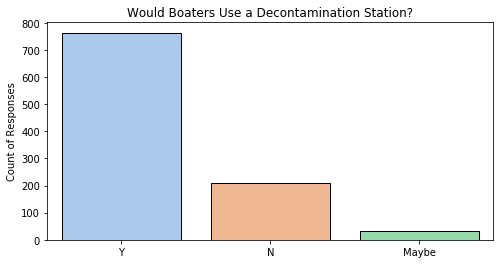

In [38]:
fig = plt.figure(figsize=(8,4))
ax = sb.countplot(x='Would Use a Decontamination Station?', data=df7, edgecolor=(0,0,0), palette='pastel')
ax.set(xlabel=None,ylabel='Count of Responses', title='Would Boaters Use a Decontamination Station?')
plt.show()

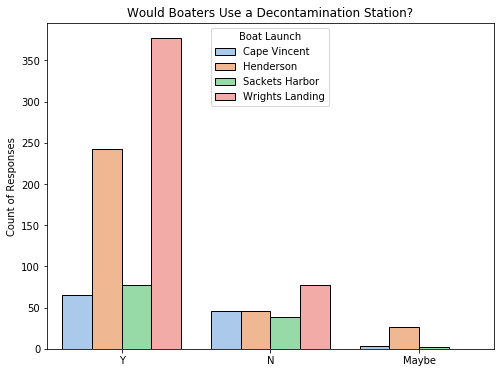

In [39]:
fig = plt.figure(figsize=(8,6))
ax = sb.countplot(x='Would Use a Decontamination Station?', hue='Boat Launch', data=df7, 
                  edgecolor=(0,0,0), palette='pastel')
ax.set(xlabel=None,ylabel='Count of Responses', title='Would Boaters Use a Decontamination Station?')
plt.show()

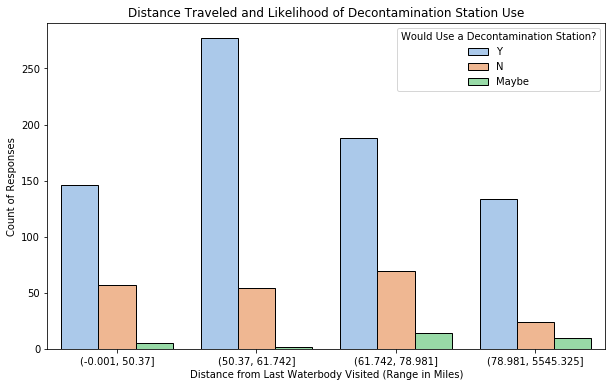

In [40]:
fig = plt.figure(figsize=(10,6))
ax = sb.countplot(x='Quantile_Dist_Prev1', hue='Would Use a Decontamination Station?', data=df7, 
                  edgecolor=(0,0,0), palette='pastel')
ax.set(xlabel='Distance from Last Waterbody Visited (Range in Miles)', ylabel='Count of Responses', 
       title='Distance Traveled and Likelihood of Decontamination Station Use')
plt.show()

When looking at distances traveled, we can specify to remove the outliers using seaborn's 'showfliers' argument. This helps accomodate the variance in minimum and maximum distances involved in travel results.

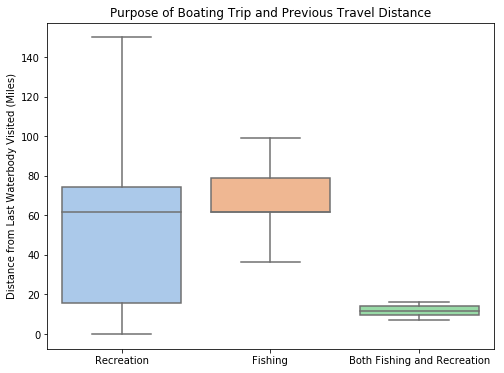

In [42]:
# looking at distances traveled, removing outliers
fig = plt.figure(figsize=(8,6))
ax = sb.boxplot(x='Purpose', y='Dist_Miles_Prev1', data=df7, palette='pastel',showfliers=False)
ax.set(xlabel=None, ylabel='Distance from Last Waterbody Visited (Miles)', 
       title='Purpose of Boating Trip and Previous Travel Distance')
plt.show()

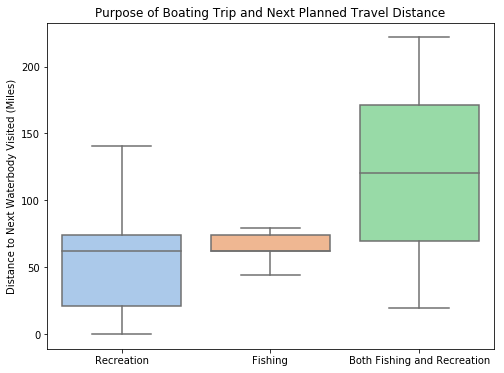

In [43]:
fig = plt.figure(figsize=(8,6))
ax = sb.boxplot(x='Purpose', y='Dist_Miles_Next1', data=df7, palette='pastel',showfliers=False)
ax.set(xlabel=None, ylabel='Distance to Next Waterbody Visited (Miles)', 
       title='Purpose of Boating Trip and Next Planned Travel Distance')
plt.show()

Create a datafrane with only the responses where aquatic organisms were identified, and plot the instances of each invasive species type.

In [44]:
species_found = df7.loc[df['Aquatic Organisms Found?'] == 'Y']

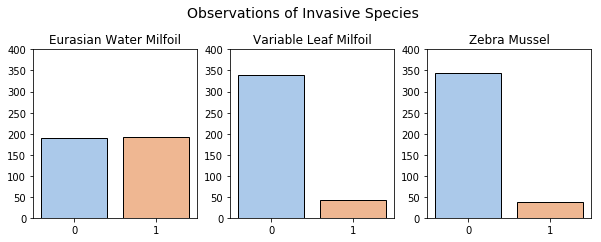

In [46]:
fig = plt.figure(figsize=(10,10))
fig_dims = (3, 3)

ax1 = plt.subplot2grid(fig_dims, (0, 0))
a = sb.countplot(x='Species_EWM', data=species_found, edgecolor=(0,0,0), palette='pastel')
plt.ylim(0,400)
a.set(xlabel=None, ylabel=None, title='Eurasian Water Milfoil')
ax2 = plt.subplot2grid(fig_dims, (0, 1))
b = sb.countplot(x='Species_VLM', data=species_found, edgecolor=(0,0,0), palette='pastel')
plt.ylim(0,400)
b.set(xlabel=None, ylabel=None, title='Variable Leaf Milfoil')
ax3 = plt.subplot2grid(fig_dims, (0, 2))
c = sb.countplot(x='Species_ZM', data=species_found, edgecolor=(0,0,0), palette='pastel')
plt.ylim(0,400)
c.set(xlabel=None, ylabel=None, title='Zebra Mussel')
fig.suptitle('Observations of Invasive Species', fontsize=14)
fig.subplots_adjust(top=0.92)
plt.show()